# Puget Sound Regional Council Household Travel Survey (PSRC HTS) Tutorial

PSRC is the metroplitan planning organization (MPO) that spans King, Kitsap, Pierce and Snohomish County in Washington State. Every few years, they conduct a regional household travel survey collecting both socioedmographic and travel behavior data of a small sample of individuals in the region.

Please obtain the PSRC HTS data from their website for the persons, household, and trips level. Additional information is available for further reading.
https://household-travel-survey-psregcncl.hub.arcgis.com/

Surveys are collected either via a smartphone app or online. Additional trace data is generated from the smartphone survey (only available 2017/2019). Online survey data generates rough O/D lat/lon information (available for 2017, 2019, and 2021).


## Step 1: Read in datasets

**Trips:** trip-level information, such as depart/arrival time, origin/dest purpose, O/D census tracts, length of trip, speed, mode, etc.

**Persons:** person-level information, such as age, race, gender, employment status, industry, etc. 

**Households:** household-level information, such as size, number of children, lifecycle, location of home, attiudinal characteristics, etc.

See the codebook (at above link) for all available variables and decoding.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.stats.weightstats import DescrStatsW
import geopandas as gpd
from shapely.geometry import Point
import requests
from pyproj import CRS
import geopy.distance
import math

In [2]:
# load datasets
# download these fro PSRC's website
trips = pd.read_csv("data/Household_Travel_Survey_Trips.csv")
persons = pd.read_csv("data/Household_Travel_Survey_Persons.csv")
households = pd.read_csv("data/Household_Travel_Survey_Households.csv")

# download this from github-- PRIVATE
od = pd.read_csv("data/od_data/trips_2017_2019_2021_locations.csv")

/var/folders/mg/5x982c514sl0dc5v1pd9gj580000gn/T/ipykernel_3095/1582395391.py:3: DtypeWarning: Columns (5,8,25,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,52,68,69,73,75,76,86,87,88,89,90,91,92,93,94,95,96,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,130,131,132,133,134,135,136,137,138,139,140,142,154) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv("data/Household_Travel_Survey_Trips.csv")
/var/folders/mg/5x982c514sl0dc5v1pd9gj580000gn/T/ipykernel_3095/1582395391.py:4: DtypeWarning: Columns (1,3,7,23,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,77,78,81,84,85,95,96,97,98,99,100,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,135,136,137,138,139,140,141,142,143,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  persons = pd.read_csv("data/Household_Travel_Survey_Persons.csv")


In [3]:
# what information do we have?
for col in persons.columns: print(col)

household_id
hhgroup
survey_year
sample_source
seattle_home
hh_race_category
sample_segment
cityofseattle
final_home_puma10
final_home_uvnum
hhsize
vehicle_count
lifecycle
hhincome_broad
hhincome_detailed
car_share
rent_own
res_dur
res_type
prev_home_wa
res_factors_30min
res_factors_afford
res_factors_closefam
res_factors_hhchange
res_factors_hwy
res_factors_school
res_factors_space
res_factors_transit
res_factors_walk
numadults
numchildren
numworkers
offpark_cost
prev_res_factors_housing_cost
prev_res_factors_income_change
prev_res_factors_community_chan
prev_res_factors_hh_size
prev_res_factors_more_space
prev_res_factors_less_space
prev_res_factors_employment
prev_res_factors_school
prev_res_factors_crime
prev_res_factors_quality
prev_res_factors_forced
prev_res_factors_no_answer
prev_res_factors_other
prev_res_factors_specify
prev_res_factors_covid_flexibil
prev_res_factors_covid_health
broadband
industry
person_id
age
age_category
gender
employment
jobs_count
student
schooltype
ed

# Step 2: Clean data

#### What do we need to clean?
- Outliers (travel time, spatial)
- Research-question specific (weekend data, specific trip purposes, etc.)
- Missing/no repsonse 

In [4]:
# let's check weekend data. codebook say 1 is Monday, 7 is Sunday.
trips.daynum.value_counts(normalize=True)

1    0.403038
4    0.107687
5    0.105821
3    0.102661
2    0.099428
7    0.092138
6    0.089139
0    0.000088
Name: daynum, dtype: float64

Looks like our weekend trips are underrepresented, only accounting for ~18% of the data (assuming people make equal trips each day, ~28.6% would be representative).

Let's see how travel time looks...

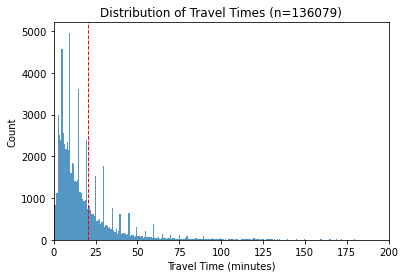

In [5]:
sns.histplot(trips.travel_time)
plt.xlim(0, 200)
plt.xlabel("Travel Time (minutes)")
plt.title(f"Distribution of Travel Times (n={len(trips)})")
plt.axvline(trips.travel_time.mean(), color='red', linestyle='dashed', linewidth=1)

# note: this is UNWEIGHTED and should not be interpreted for region-wide analysis

In [6]:
trips.travel_time.describe()

count    72850.00000
mean        20.56950
std         49.17555
min          0.00000
25%          6.30000
50%         12.10000
75%         22.37500
max       4646.20000
Name: travel_time, dtype: float64

Looks like we have a pretty long tail of travel times. Also notice some respondent bias-- people tend to think of their travel time in intervals of five. 

Since a lot of accessibility/mobility metrics can be derived from travel time, let's check the quality of the data.

In [7]:
# check for missing values
trips.travel_time.isna().value_counts() # uh oh, 63,000 missing values?????

False    72850
True     63229
Name: travel_time, dtype: int64

In [8]:
# are we missing as many datetime strings?
print(trips.arrival_time_string.isna().value_counts(), '\n') # looks a lot better, only 6 missing
print(trips.depart_time_string.isna().value_counts()) # only 20 missing


False    136073
True          6
Name: arrival_time_string, dtype: int64 

False    136059
True         20
Name: depart_time_string, dtype: int64


In [9]:
# let's drop the missing datetime strings
trips_clean = trips.dropna(subset=['depart_time_string', 'arrival_time_string']) # this only drops 23 observations

In [10]:
# let's manually calculate them using the start and end times. this way we can preserve many more observations.

def travel_time_manual(row):
    ''' 
    function to calculate travel time from datetime arrival/depart strings.
    input: row of dataframe
    output: travel time in minutes
    '''
    date_str_arr = row.arrival_time_string[:-1]
    date_str_dep = row.depart_time_string[:-1]
    date_format = "Date: %Y-%m-%d %H:%M:%S.%f"

    # convert string to datetime object
    dt_object_arr = datetime.strptime(date_str_arr, date_format)
    dt_object_dep = datetime.strptime(date_str_dep, date_format)
    
    # calculate travel time
    delta_time = abs(dt_object_arr - dt_object_dep)
    travel_time_mins = delta_time.total_seconds()/60

    return travel_time_mins

In [11]:
trips_clean.loc[:, "travel_time_calc"] = trips_clean.apply(travel_time_manual, axis=1)

/var/folders/mg/5x982c514sl0dc5v1pd9gj580000gn/T/ipykernel_3095/548063521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_clean.loc[:, "travel_time_calc"] = trips_clean.apply(travel_time_manual, axis=1)


In [12]:
trips_clean.travel_time_calc.isna().value_counts() # no missing values

False    136056
Name: travel_time_calc, dtype: int64


To create a final, cleaned dataset, let's say we want to look at just workday trips. We can assume that a "normal" trip is under 2 hours (adjust this for your purposes) since people need to go to schoo/work.

In [13]:
# filter dataset
trips_clean = trips_clean[(trips_clean.travel_time_calc < 120) & (trips_clean.daynum.isin([1,2,3,4,5]))]

In [14]:
# how much is retained?
print(f"{len(trips_clean)/len(trips)*100:.2f}% of the original dataset is retained after filtering.")

81.02% of the original dataset is retained after filtering.


# Step 3. Summary Statistics

Ok, so the above give us an idea of the *sample* behaviors, but how can we generalize this to the entire Puget Sound region?
- Survey weights!
    - Generally, apply weights to each year. See codebook for more detail.
    - Note: survey weights are used so that the sampled individuals match ACS data, and that trip modes/purposes are representative. Read more here: https://www.psrc.org/media/3631

Using survey weights, we can make accurate comparisons between years when describing our data. Weights are needed for things such as visualizations and summary statistics, but not for models (since in models we want to understand relationships, which does not require representativeness).



Here's a cheatsheet for weighting:
| Summary level | 2017 | 2019 | 2017/2019 | 2021
| --- | --- | --- | --- | --- |
| Household | hh_weight_2017_v2021 | hh_weight_2019_v2021 | hh_weight_2017_2019_v2021 | hh_weight_2021_ABS |
| Person | hh_weight_2017* | hh_weight_2019* | hh_weight_2017_2019* | person_adult_weight_2021 |
| Trip | trip_weight_2017_v2021* | trip_weight_2019_v2021* | trip_weight_2017_2019_v2021* | trip_weight_2021_ABS_Panel_adult |
| Respondent | | | | Apply to articular questions** |

Notice there are some adult weights too-- 2021 sample does not contain children, while 2017/2019 does. So to compare trips between 2017/2019 and 2021, need to filter to only adult trips before applying weights. DO NOT COMPARE TRIPS WEIGHTED WITH CHILDREN TO WEIGHTS THAT DO NOT CONSIDER CHILDREN.

*: filter to adults only first to compare to 2021

**: respondent weights only apply to 2021 sample for
- workplace_pre_covid
- commute_freq_pre_covid
- commute_mode_pre_covid
- telecommute_freq_pre_covid
- employment_change_employer
- employment_change_location
- employment_change_new_job
- employment_change_laid_off
- employment_change_left_workforce
- employment_change_none

In [15]:
# notice that person, household, and trip dfs all have survey weights
trips_clean.iloc[:, -8:-2]

,trip_weight_2021_ABS_Panel_adul,trip_weight_2021_ABS_Panel_resp,trip_weight_2017_v2021,trip_weight_2019_v2021,trip_weight_2017_2019_v2021,trip_weight_2017_2019_v2021_adu
0,665.450454,0.000000,NaN,NaN,NaN,NaN
1,665.450454,0.000000,NaN,NaN,NaN,NaN
2,80.162855,81.053177,NaN,NaN,NaN,NaN
3,80.162855,81.053177,NaN,NaN,NaN,NaN
4,109.823112,111.042852,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
136072,NaN,NaN,NaN,12.224092,6.112046,NaN
136073,NaN,NaN,NaN,12.224092,6.112046,NaN
136074,NaN,NaN,NaN,12.224092,6.112046,NaN
136075,NaN,NaN,NaN,12.224092,6.112046,NaN


Text(0.5, 1.0, 'Distribution of Travel Times in 2017, Weight Comparison')

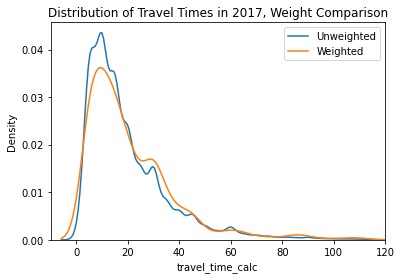

In [16]:
# so, how do we apply weights?
# visually
sns.kdeplot(trips_clean[trips_clean.survey_year ==2017].travel_time_calc, label="Unweighted")
sns.kdeplot(trips_clean[trips_clean.survey_year ==2017].travel_time_calc, weights=trips_clean.trip_weight_2017_v2021, label="Weighted")
plt.xlim(-10, 120)
plt.legend()
plt.title("Distribution of Travel Times in 2017, Weight Comparison")

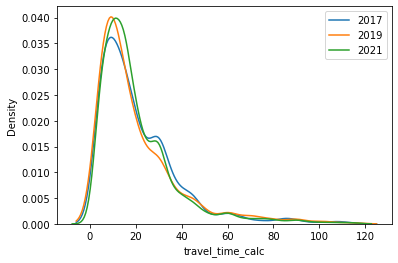

In [17]:
# now, with weights, we can compare trips between years

# filter 2017/2019 to be adult only
trips_clean_adults = trips_clean[(trips_clean.age != "Under 5 years old") | (trips_clean.age != "5-11 years") | 
                                 (trips_clean.age != "12-15 years") | (trips_clean.age != "16-17 years")]

# now we can compare weighted trips across years
sns.kdeplot(trips_clean_adults[trips_clean_adults.survey_year ==2017].travel_time_calc, weights=trips_clean_adults.trip_weight_2017_v2021, label="2017")
sns.kdeplot(trips_clean_adults[trips_clean_adults.survey_year ==2019].travel_time_calc, weights=trips_clean_adults.trip_weight_2019_v2021, label="2019")
sns.kdeplot(trips_clean_adults[trips_clean_adults.survey_year ==2021].travel_time_calc, weights=trips_clean_adults.trip_weight_2021_ABS_Panel_adul, label="2021")
plt.legend()

In [18]:
# weighted descriptive statistics
trips_clean_2017 = trips_clean[trips_clean.survey_year == 2017]

# from statsmodels
ws_tt = DescrStatsW(trips_clean_2017.travel_time_calc, weights=trips_clean_2017.trip_weight_2017_v2021)
quantiles = ws_tt.quantile(probs=np.array([0.25,0.5,0.75]), return_pandas=False)
desc_stats = {"mean": ws_tt.mean, "std": ws_tt.std, "25th percentile": quantiles[0],
              "50th percentile": quantiles[1], "75th percentile": quantiles[2],
              "min": trips_clean_2017.travel_time_calc.min(), "max": trips_clean_2017.travel_time_calc.max()}
desc_stats 

{'mean': 21.28245727349073,
 'std': 17.600862721370405,
 '25th percentile': 10.0,
 '50th percentile': 15.0,
 '75th percentile': 30.0,
 'min': 0.0,
 'max': 119.0}

# Step 4: Mobility metrics
Let's calculate some metrics on the daily, person level
- number of trips
- VMT
- person miles traveled
- trip chains


In [19]:
# need data for each person each day
person_day_df = trips_clean.groupby(['person_dim_id', 'daynum']).size().reset_index()[['person_dim_id', 'daynum']]
person_day_df

,person_dim_id,daynum
0,1710000501,1
1,1710000502,1
2,1710002401,1
3,1710002402,1
4,1710002403,1
...,...,...
24667,19201842502,3
24668,19201842502,4
24669,19201842502,5
24670,19201842503,1


In [20]:
def mobility_metrics(row):
    ''' 
    function that calculates mobility metrics
    input: df row
    output: pandas series of metrics
    '''
    # filter to obtain trips that correspond with each person
    trips_day_person = trips_clean[(trips_clean.person_dim_id == row.person_dim_id) & (trips_clean.daynum == row.daynum)]

    # number of trips
    num_trips = len(trips_day_person)

    # person miles traveled
    pmt = trips_day_person.trip_path_distance.sum()

    # vehicle miles traveled
    vmt = trips_day_person.loc[trips_day_person['mode_simple'] == 'Drive', 'trip_path_distance'].sum()

    # trip chains
    trip_chains = 0
    start_home = False
    for idx, row in trips_day_person.iterrows():
        if row.origin_purpose == "Went home":
            start_home = True
        if (row.dest_purpose != "Went home") and start_home: # person continues their trip chain
            continue
        elif (row.dest_purpose == "Went home") and (row.origin_purpose == "Went home"): # home-home trip, not counted as a trip chain
            continue
        elif (row.dest_purpose == "Went home") and start_home: # end of the trip chain
            trip_chains += 1
            start_home = False # reset flag
    
    return pd.Series([num_trips, pmt, vmt, trip_chains])


In [21]:
person_day_df[['num_trips', 'pmt', 'vmt', 'trip_chains']] = person_day_df.apply(mobility_metrics, axis=1)
person_day_df

,person_dim_id,daynum,num_trips,pmt,vmt,trip_chains
0,1710000501,1,5.0,22.857132,22.857132,2.0
1,1710000502,1,3.0,6.685952,6.685952,1.0
2,1710002401,1,8.0,9.758632,6.618844,4.0
3,1710002402,1,4.0,4.642263,1.690129,2.0
4,1710002403,1,2.0,1.722440,0.799083,1.0
...,...,...,...,...,...,...
24667,19201842502,3,5.0,23.004820,22.557380,1.0
24668,19201842502,4,4.0,22.866480,22.425730,1.0
24669,19201842502,5,2.0,3.142820,3.142820,1.0
24670,19201842503,1,3.0,12.906050,12.906050,1.0


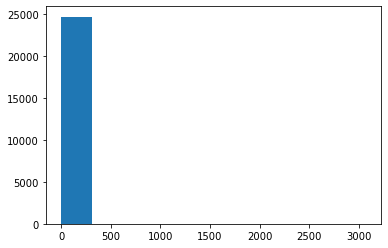

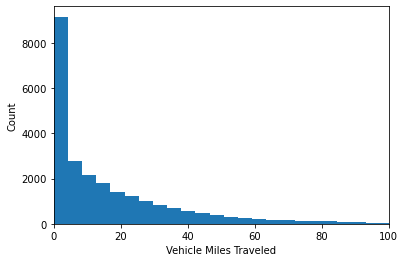

In [22]:
# visualize VMT-- let's not use weights here since it gets a little tricky since
# we're at both the person and trip level
plt.hist(person_day_df.vmt)
plt.show()

# still looks like there's an outlier...let's drop it
person_day_df_clean = person_day_df[person_day_df.vmt < 500]
plt.hist(person_day_df_clean.vmt, bins=100)
plt.xlim(0, 100)
plt.xlabel("Vehicle Miles Traveled")
plt.ylabel("Count")
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb22c1aa0d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb22c1a8e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb22c1aa6a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb22c1a8430>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb22c1a8760>],
 'means': []}

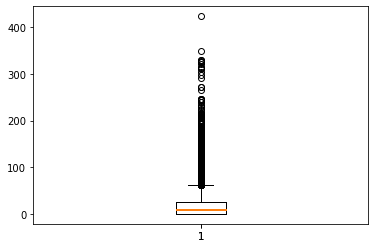

In [23]:
# what about vmt by gender?
# merge person data with person_day_df
person_day_df_clean = person_day_df_clean.merge(persons[["person_id", "gender"]], left_on='person_dim_id', 
                                                right_on="person_id", how='left')

Female mean VMT: 15.983421705421357 
Male mean VMT: 15.666777776732333


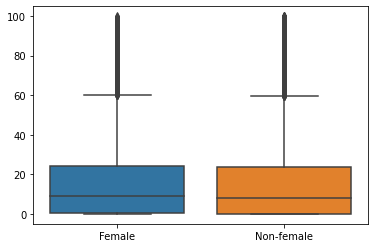

In [42]:
# let's drop some outliers
person_day_df_clean = person_day_df_clean[person_day_df_clean.vmt < 100]

# let's split up by gender
person_day_df_clean_fem = person_day_df_clean[person_day_df_clean["gender"] == "Female"]
person_day_df_clean_nonfem = person_day_df_clean[person_day_df_clean["gender"] != "Female"]

sns.boxplot(data=[person_day_df_clean_fem.vmt, person_day_df_clean_nonfem.vmt])
plt.xticks(ticks=[0,1], labels=["Female", "Non-female"])

print("Female mean VMT:", person_day_df_clean_fem.vmt.mean(), "\nMale mean VMT:", person_day_df_clean_nonfem.vmt.mean())
# can perform t-test to determine significance

# Bonus: O/D data + mapping
We can also use O/D data collected from the online survey to calculate some more spatial metrics, such as radius of gyration (activity space).

However, we need to clean this data too!

In [24]:
# filter out trips outside WA
def are_points_inside_washington(origin_lat, origin_lng, dest_lat, dest_lng):
    washington_bbox = {
    'lat_min': 45.5435,
    'lat_max': 49.0025,
    'lon_min': -124.848974,
    'lon_max': -116.916197
    }
    return (washington_bbox['lat_min'] <= origin_lat <= washington_bbox['lat_max']) and \
           (washington_bbox['lon_min'] <= origin_lng <= washington_bbox['lon_max']) and \
           (washington_bbox['lat_min'] <= dest_lat <= washington_bbox['lat_max']) and \
           (washington_bbox['lon_min'] <= dest_lng <= washington_bbox['lon_max'])

In [25]:
# create gdf for O/D trips
gdf_od = gpd.GeoDataFrame(od, geometry=gpd.points_from_xy(od['origin_lng'], od['origin_lat']), crs={'init':'EPSG:4326'})

# get rid of nas
gdf_od = gdf_od.dropna(subset=['origin_lng', 'origin_lat', 'dest_lng', 'dest_lat'])

# limit data to washington state
gdf_od['Both_Points_Inside_Washington'] = gdf_od.apply(lambda row: are_points_inside_washington(row['origin_lat'],
                                                                                         row['origin_lng'],
                                                                                         row['dest_lat'],
                                                                                         row['dest_lng']), axis=1)
gdf_od = gdf_od[gdf_od.Both_Points_Inside_Washington == True]

/Users/kaitlynng/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [26]:
# load in washington state counties
counties_url = "https://gisdata.kingcounty.gov/arcgis/rest/services/OpenDataPortal/politicl___base/MapServer/122/query?outFields=*&where=1%3D1&f=geojson"
response = requests.get(counties_url)
data = response.json()
gdf_counties = gpd.GeoDataFrame.from_features(data['features'], crs={'init':'EPSG:4326'})

# adjust crs
gdf_counties = gdf_counties.to_crs(epsg=4326)

/Users/kaitlynng/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


/Users/kaitlynng/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/var/folders/mg/5x982c514sl0dc5v1pd9gj580000gn/T/ipykernel_3095/3251347616.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


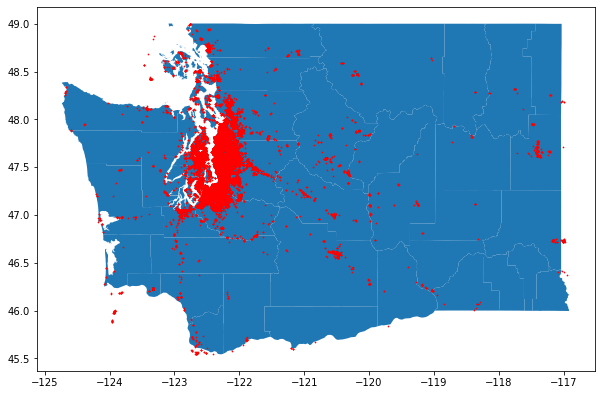

In [27]:
# plot
fig, ax = plt.subplots(figsize=(10,10))
gdf_counties.plot(ax=ax)
gdf_od.plot(ax=ax, color='red', markersize=0.5)
fig.show()

Now, we can calculate radius of gyration.

In [28]:
# merge trip and o/d data
trips_od = pd.merge(trips_clean, od, on=["trip_id", "household_id"], how="left")

In [29]:
def rog(points, centroid):
    '''
    this function is calculates rog given unique points
    points: list of points; centroid: (x,y)
    returns radius of gyration
    '''
    d_i = [geopy.distance.geodesic(points[p], (centroid[1], centroid[0])).miles for p in range(len(points))]
    n = len(d_i)
    sum_di = 0
    for i in range(n):
        sum_di += d_i[i]**2
    rog = math.sqrt(sum_di/n)
     
    return rog

In [30]:
def rog_centroid_df(row):
    '''
    this function calculates the radius of gyration (ROG) for each person, using UNIQUE points
    person_od_df: df with all trips made by a single individual
    return rog_centroid, rog_home: ROG based around centroid, ROG based around home 
    '''
    # filter df by personid
    person_trips_df = trips_od[trips_od.person_dim_id == row.person_id]

    # get uique points
    unique_lat = set()
    unique_lng = set()
    unique_pts = set()
    for idx, row in person_trips_df.iterrows():
        olat = round(row.origin_lat, 3)
        olng = round(row.origin_lng, 3)
        dlat = round(row.dest_lat, 3)
        dlng = round(row.dest_lng, 3)
        unique_lat.add(olat)
        unique_lat.add(dlat)
        unique_lng.add(olng)
        unique_lng.add(dlng)
        unique_pts.add((olat, olng))
        unique_pts.add((dlat, dlng))
    # calculate centroid lat/lon
    centroid = (np.mean(list(unique_lng)), np.mean(list(unique_lat)))
    
    try:
        # calculate ROG around centroid
        rog_centroid = rog(list(unique_pts), centroid)
        return rog_centroid
    except:
        return None

In [31]:
persons["rog"] = persons.apply(rog_centroid_df, axis=1)

/Users/kaitlynng/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kaitlynng/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Trace data is also available for 2017 data (and for 2019, though we do not have that data from PSRC). See more examples of trace data with Minda & Jaime's work from the summer.